# Import Dependencies

In [1]:
!pip install rawpy  # install rawpy

ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\macvi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import rawpy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch as th

# Load Raw Images

In [3]:
def get_rgb_values(image_path, bayer_array=None, **kwargs):
    with rawpy.imread(image_path) as raw:
        if bayer_array is not None:
            raw.raw_image[:] = bayer_array
        rgb = raw.postprocess(**kwargs)
    return rgb

In [4]:
def load_raw_images(files_path):
    """Load raw images from the given path"""
    raw_images = []
    for path in files_path:
        with rawpy.imread(path) as raw:
            # print noise model of the raw image
            raw_images.append(raw.raw_image.copy())
    raw_images = np.stack(raw_images)
    raw_images = raw_images.astype(np.float32)
    return raw_images

In [5]:
folder_path = "./c1b1_20150226_144326_422"
# folder_path = "./0127_20161107_171749_524"
dng_files_path = ['{}/{}'.format(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".dng")]

In [6]:
raw_images = load_raw_images(dng_files_path)
print("loaded raw images with shape: ", raw_images.shape)

loaded raw images with shape:  (10, 2464, 3280)


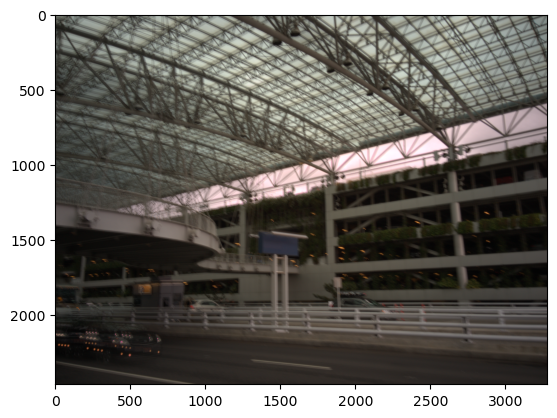

In [7]:
def naive_align(raw_images):
    """Find Average across all images"""
    return np.mean(raw_images, axis=0)

naive_aligned_image = naive_align(raw_images)
naive_rgb_image = get_rgb_values(dng_files_path[1], bayer_array=naive_aligned_image, no_auto_bright=False)

plt.imshow(naive_rgb_image)
plt.show()

# Aligning
- Use Handheld Multi-Frame Super-Resolution Paper (Google's approach to Super-Res Zoom and Night Sight Mode)
- Uses signals captured across multiple shifted frames to produce higher resolution images 

In [8]:
#  TODO: Verify correctness against dataset
def select_reference_image(raw_images):
    """Select the reference image from the given raw images"""
    gradient_magnitudes = []
    d_depth = cv2.CV_64F
    for i in range(raw_images.shape[0]):
        image = raw_images[i, :, :]
        sobel_x = cv2.Sobel(image, d_depth, 1, 0, ksize=3) 
        sobel_y = cv2.Sobel(image, d_depth, 0, 1, ksize=3) 

        # TODO: Optimize this by using the sum of the absolute values of the gradient
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2).sum()
        gradient_magnitudes.append(gradient_magnitude)

    return gradient_magnitudes.index(max(gradient_magnitudes))

max_gradient_magnitude_index = select_reference_image(raw_images[:3])

In [9]:
def gaussian_downsample(image, downsample_factor):
    """Downsample the given image using Gaussian pyramid"""
    downsampled_image = image
    two_d_kernel = cv2.getGaussianKernel(3, 0.1)

    for _ in range(downsample_factor//2):
        height, width = downsampled_image.shape[:2]
        downsampled_image = cv2.filter2D(downsampled_image, -1, two_d_kernel)
        downsampled_image = cv2.resize(downsampled_image, (width // 2, height // 2), interpolation=cv2.INTER_LINEAR)
    return downsampled_image

test_array = np.random.randint(0, 255, (512, 256)).astype(np.float32)
downsampled_image = gaussian_downsample(test_array, 4)
print("downsampled image shape: ", downsampled_image.shape)

downsampled image shape:  (128, 64)


In [10]:
def upsample_image(image, height, width):
    """Nearest-neighbor upsample the given image to the given shape"""
    if len(image.shape) > 3:
        return np.array([upsample_image(image[i], height, width) for i in range(image.shape[0])])
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)

test_array = np.random.randint(0, 255, (128, 64), dtype=np.int32)
downsampled_image = upsample_image(test_array, 512, 256)
print("upsampled image shape: ", downsampled_image.shape)

upsampled image shape:  (512, 256)


In [11]:
def generate_pyramid(images, pyramid_levels=4, downsample_factor=4):
    """Generate Gaussian pyramid for the given image"""
    pyramid_images = []
    for i in range(0, pyramid_levels):
        pyramid_level = []
        for j in range(images.shape[0]):
            if i == 0:
                pyramid_level.append(images[j])
            else:
                downsampled_image = gaussian_downsample(pyramid_images[-1][j], downsample_factor)
                pyramid_level.append(downsampled_image)
        pyramid_images.append(pyramid_level)
    return pyramid_images

pyramid_images = generate_pyramid(np.zeros_like(raw_images), pyramid_levels=4)
print(pyramid_images[0][0].shape, pyramid_images[1][0].shape, pyramid_images[2][0].shape, pyramid_images[3][0].shape)

(2464, 3280) (616, 820) (154, 205) (38, 51)


In [12]:
# TODO: Consider out of the box alignment algorithms
# TODO: Consider using sparse motion vectors
def align_level_images(level, pyramid_level_images, motion_matrix, reference_image_index, block_size=16, search_window=4):
    level_reference_image = pyramid_level_images[reference_image_index]
    x_max, y_max = level_reference_image.shape

    for i in tqdm(range(raw_images.shape[0])):
        image_offset = motion_matrix[i]
        
        for x in range(0, x_max, block_size):
            for y in range(0, y_max, block_size):
                # Initialize the best match and the best match error
                best_match = np.zeros(3)
                best_match_error = np.inf

                end_x = min(x + block_size, x_max)
                end_y = min(y + block_size, y_max)

                reference_block = level_reference_image[x:end_x, y:end_y]
                offset = image_offset[x, y]

                for x_offset in range(-search_window + offset[0], search_window  + offset[0]):
                    for y_offset in range(-search_window + offset[1], search_window + offset[1]):

                        x_start = max(0, x + x_offset)
                        x_end = min(x + x_offset + block_size, x_max)

                        y_start = max(0, y + y_offset)
                        y_end = min(y + y_offset + block_size, y_max)

                        target_block = pyramid_level_images[i][x_start:x_end, y_start:y_end]

                        if reference_block.shape != target_block.shape:
                            continue

                        # L2 norm
                        if level < 2:
                            # [TODO]: Implement optimized L2 norm
                            block_error = np.sum((reference_block - target_block)**2)
                        else:
                            block_error = np.sum(np.abs(reference_block - target_block))

                        if block_error < best_match_error:
                            best_match_error = block_error
                            best_match = np.array([x_offset, y_offset, 0])

                motion_matrix[i][x:end_x, y:end_y, :] = best_match
    return motion_matrix

In [13]:
#[TODO]: Experiment with different search window sizes
#[TODO]: Optimize last level of pyramid
def burst_align(reference_image_index, raw_images):
    """Pyramid block matching algorithm"""
    pyramid_levels = 4
    downsample_factor = 4

    pyramid_images = generate_pyramid(raw_images, pyramid_levels, downsample_factor)
    # Arrange the pyramid images in descending order
    pyramid_images = pyramid_images[::-1]
    pyramid_shapes = [image[0].shape for image in pyramid_images]
    print("pyramid shapes: ", pyramid_shapes)

    # Initialize the motion vectors to zeros initially
    motion_matrix = np.zeros((raw_images.shape[0], pyramid_shapes[0][0], pyramid_shapes[0][1],  3), dtype=np.int32)

    for level in range(pyramid_levels):
        if level != 0:
            motion_matrix = upsample_image(motion_matrix, pyramid_shapes[level][0], pyramid_shapes[level][1]) * downsample_factor

        motion_matrix = align_level_images(level, pyramid_images[level], motion_matrix, reference_image_index, block_size=8 if level < 2 else 16, search_window=4)

        # Update the motion vectors
    return motion_matrix

In [14]:
# A coarse-to-fine, pyramid-based block matching that creates a pyramid representation of every input frame and performs a limited window search to find the most similar tile

# Choose reference frame selection from top 3 based on lucky imaging
reference_image = raw_images[max_gradient_magnitude_index]
print("selected reference image with index: ", max_gradient_magnitude_index)

# Downsample the raw images to speed up alignment
downsampled_raw_images = np.array([gaussian_downsample(raw_image, 2) for raw_image in raw_images])
print("downsampled raw images with shape: ", downsampled_raw_images[0].shape, "previous shape: ", raw_images[0].shape)

# Generate alignment matrix using pyramid block matching
motion_matrix = burst_align(max_gradient_magnitude_index, downsampled_raw_images)

selected reference image with index:  0
downsampled raw images with shape:  (1232, 1640) previous shape:  (2464, 3280)
pyramid shapes:  [(19, 25), (77, 102), (308, 410), (1232, 1640)]


100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


In [15]:
def align(motion_matrix, raw_images, block_size=16):
    aligned_burst_patches = []
    for i in tqdm(range(raw_images.shape[0])):
        upscaled_image = upsample_image(motion_matrix[i], raw_images.shape[1], raw_images.shape[2]) * 2
        x_max, y_max = upscaled_image.shape[:2]
        aligned_image_patches = []

        for x in range(0, x_max, block_size):
            aligned_row_patches = []
            for y in range(0, y_max, block_size):
                best_match = upscaled_image[x, y]
                start_x = min(x + best_match[0], x_max)
                end_x = min(start_x + block_size, x_max)
                start_y = min(y + best_match[1], y_max)
                end_y = min(start_y + block_size, y_max)

                aligned_row_patches.append(raw_images[i][start_x:end_x, start_y:end_y])
            aligned_image_patches.append(aligned_row_patches)
        aligned_burst_patches.append(aligned_image_patches)

    return aligned_burst_patches

In [16]:
aligned_burst_patches = align(motion_matrix, raw_images)

got here


  0%|          | 0/10 [00:00<?, ?it/s]

got in
2464 3280 16
got in
2464 3280 16


 30%|███       | 3/10 [00:00<00:00,  8.90it/s]

got in
2464 3280 16
got in
2464 3280 16


 50%|█████     | 5/10 [00:00<00:00,  8.17it/s]

got in
2464 3280 16
got in


 70%|███████   | 7/10 [00:00<00:00,  7.75it/s]

2464 3280 16
got in
2464 3280 16


 80%|████████  | 8/10 [00:00<00:00,  7.76it/s]

got in
2464 3280 16
got in
2464 3280 16


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]

got in
2464 3280 16


# Merge

In [ ]:
def merge_images(aligned_images, reference_image_index):
    """Merge the given raw images using the given motion matrix"""
    # [TODO]: What is the point of DFT here? Why can't we just use the motion matrix? 
    # [TODO]: Also this is prohibitively slow

    # TODO: Extract noise model from the dataset. A single value is enough because the assumption 
    # is that the noise is the roughly the same across all images shot from the same device
    
    # TODO: Consider per-patch noise model in place of global noise model
    shot_noise = 30.0
    read_noise = 5.0

    num_rows = len(aligned_images[0])
    num_cols = len(aligned_images[0][0])
    num_aligned_images = len(aligned_images)

    aligned_image = []
    for row in tqdm(range(num_rows)):
        aligned_row = []
        for col in range(num_cols):
            reference_image_patch = aligned_images[reference_image_index][row][col]
            path_rms = np.sqrt(np.mean(np.square(reference_image_patch)))
            dft_ref = th.fft.fftn(th.from_numpy(reference_image_patch), dim=(0, 1)).numpy()
            noise_variance = shot_noise * path_rms + read_noise
            temporal_factor = 32
            k = np.prod(reference_image_patch.shape) / 8
            noise = k * temporal_factor * noise_variance

            final_patch = dft_ref.copy()
            for i in range(num_aligned_images):
                if i == reference_image_index:
                    continue
                alt_dft = th.fft.fftn(th.from_numpy(aligned_images[i][row][col]), dim=(0, 1)).numpy()
                difference = dft_ref - alt_dft
                difference_squared = np.square(difference.real) + np.square(difference.imag)
                shrinkage_operator = difference_squared / (difference_squared + noise)
                final_patch += (1 - shrinkage_operator) * alt_dft + shrinkage_operator * dft_ref
            final_patch /= num_aligned_images
            final_patch = th.fft.ifftn(th.from_numpy(final_patch), dim=(0, 1)).numpy().real
            aligned_row.append(final_patch)
        aligned_image.append(aligned_row)
    # reference_image = aligned_images[reference_image_index]

    # # print("noise variance: ", noise_variance)

    # # Temporal Denoising
    # difference_squared = reference_image - aligned_images
    # difference_squared = np.square(difference_squared.real) + np.square(difference_squared.imag)
    # shrikage_operator = difference_squared  / (difference_squared + noise)

    # offset = (1 - shrikage_operator) * aligned_images + shrikage_operator * reference_image

    # temporal_denoised_frame = np.sum(offset, axis=0) / aligned_images.shape[0]
    
    # # Spatial Denoising
    # s = 10
    # noise =  np.prod(aligned_images.shape) / 16 * s
    # difference_squared = np.square(temporal_denoised_frame.real) + np.square(temporal_denoised_frame.imag)
    # shrikage_operator = difference_squared / (difference_squared + noise)
    # final_merged_frame = shrikage_operator * temporal_denoised_frame

    # final_merged_frame = th.fft.ifftn(th.from_numpy(final_merged_frame), dim=(0, 1)).numpy().real
    return aligned_image

final_merged_frame = merge_images(aligned_burst_patches, max_gradient_magnitude_index)

100%|██████████| 154/154 [00:11<00:00, 13.97it/s]


(2464, 3280)


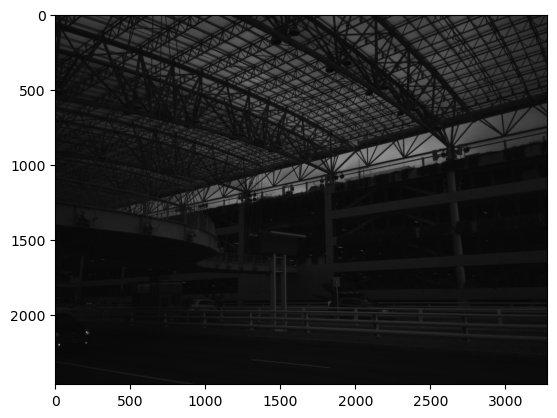

In [ ]:
stacked_patches = []
for row in final_merged_frame:
    stacked_patches.append(np.hstack(row))
final_merged_frame2 = np.vstack(stacked_patches)
print(final_merged_frame2.shape)
plt.imshow(final_merged_frame2, cmap='gray')
plt.show()

In [ ]:
ref_image_path = '../Dataset/20171106_subset/results_20161014/{}/merged.dng'.format(folder_path)
reference_rgb = load_raw_images([ref_image_path])[0]
reference_rgb = get_rgb_values(ref_image_path, bayer_array=reference_rgb, no_auto_bright=False)

In [ ]:
merged_rgb = get_rgb_values(dng_files_path[max_gradient_magnitude_index], final_merged_frame2)
merged_rgb = cv2.resize(merged_rgb, (reference_rgb.shape[1], reference_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)

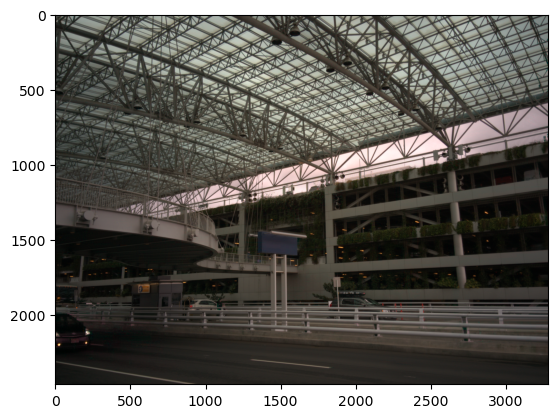

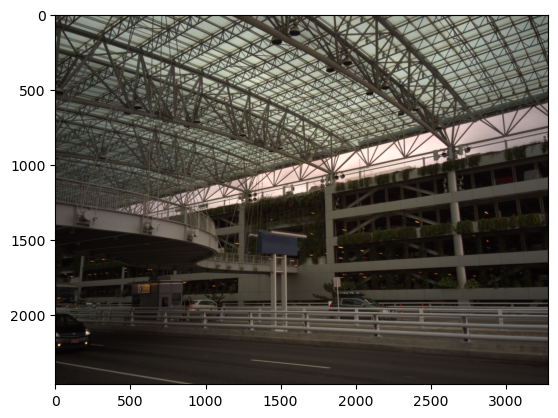

In [ ]:
plt.imshow(merged_rgb)
plt.show()

plt.imshow(reference_rgb)
plt.show()

In [ ]:
print(merged_rgb.max(), merged_rgb.min())
print(reference_rgb.max(), reference_rgb.min())

255 0
255 0


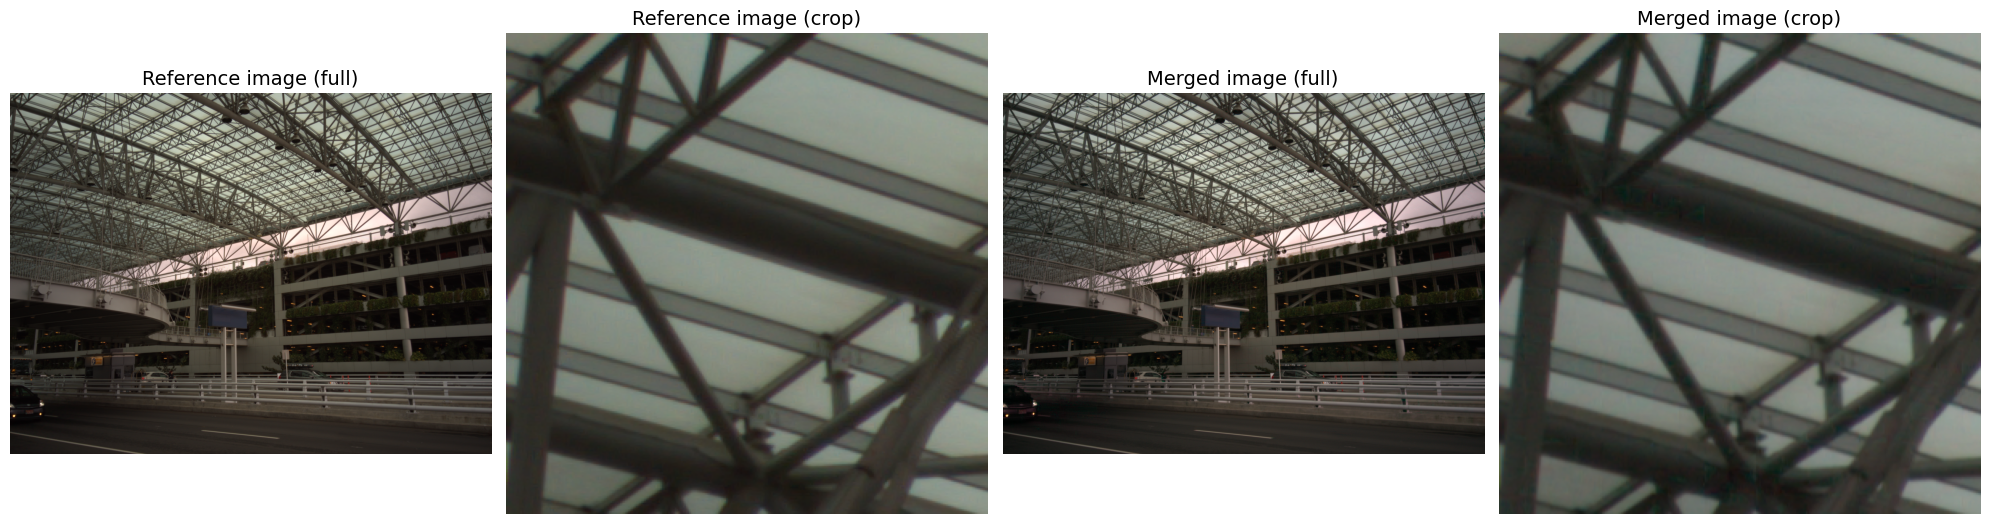

In [ ]:
# convert raw images to rgb images
brigthness = 2.5
# TODO: Fix aliasing lines

# figure
font_size = 14
fig, axs = plt.subplots(1, 4, figsize=[20, 16])

# crop
crop_y = [0, 300]
crop_x = [0, 300]

# reference image
axs[0].imshow(reference_rgb)
axs[0].set_title('Reference image (full)', fontsize=font_size)
axs[1].imshow(reference_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[1].set_title('Reference image (crop)', fontsize=font_size)

# merged burst
axs[2].imshow(merged_rgb)
axs[2].set_title('Merged image (full)', fontsize=font_size)
axs[3].imshow(merged_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[3].set_title('Merged image (crop)', fontsize=font_size)

for ax in axs:
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'before_and_after.jpg', bbox_inches='tight')
plt.show()

# Finishing